# Set up example code

## Model setup

In [1]:
import subprocess

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy.linalg import lapack
from scipy import stats
import emcee
import numpy as np

import importlib

import os
import pickle
from pathlib import Path

import src.reader as Reader

import pandas as pd

from src.functions import *

## Step 1: prepare input pickle file

### Load stuff from text files

Input Directory

In [2]:
indir = '/scratch/user/cameron.parker/projects/JETSCAPE/runs/LEPgluonmove/QVir_Analysis/'

Prepare to read design to read in

In [3]:
df = pd.read_csv(indir+'parameters.txt')
designlines = ["# 2760\n","# Version 1.0\n","# Parameter ",df.to_string(index=False)]

designfile = open("input/eedesign.txt",'w')
designfile.writelines(designlines)
designfile.close()

RawDesign = Reader.ReadDesign("input/eedesign.txt")
print(RawDesign)

{'FileName': 'input/eedesign.txt', 'Parameter': ['Q0', 'QSfactor', 'vir_factor', 'lambdaQCD', 'StringFlav:probStoUD', 'StringFlav:probQQtoQ'], 'Design': array([[1.289717, 0.234797, 0.945655, 0.41476 , 0.381634, 0.298106],
       [1.535585, 0.71301 , 0.153793, 0.214335, 0.468437, 0.315121],
       [4.556278, 0.214749, 0.496547, 0.121606, 0.048457, 0.137273],
       ...,
       [2.193216, 0.742395, 0.155477, 0.221714, 0.029617, 0.194297],
       [1.250867, 0.096768, 0.160303, 0.165722, 0.379364, 0.05731 ],
       [3.053136, 0.135346, 0.933631, 0.142044, 0.316181, 0.089209]])}


In [4]:
# Read data files
ChargedXpData = Reader.ReadData('/scratch/user/cameron.parker/projects/STAT/input/vac-data/Data_ALEPH_EpEm91_charged-xp.dat')
PionXpData = Reader.ReadData('/scratch/user/cameron.parker/projects/STAT/input/vac-data/Data_ALEPH_EpEm91_pion-xp.dat')
KaonXpData = Reader.ReadData('/scratch/user/cameron.parker/projects/STAT/input/vac-data/Data_ALEPH_EpEm91_kaon-xp.dat')
ProtonXpData = Reader.ReadData('/scratch/user/cameron.parker/projects/STAT/input/vac-data/Data_ALEPH_EpEm91_proton-xp.dat')
MultData = Reader.ReadData('/scratch/user/cameron.parker/projects/STAT/input/vac-data/Data_ALEPH_EpEm91_mult.dat')
ThrustData = Reader.ReadData('/scratch/user/cameron.parker/projects/STAT/input/vac-data/Data_ALEPH_EpEm91_thrust.dat')
JetData = Reader.ReadData('/scratch/user/cameron.parker/projects/STAT/input/vac-data/Data_ALEPH_EpEm91_inc-jets.dat')
DijetData = Reader.ReadData('/scratch/user/cameron.parker/projects/STAT/input/vac-data/Data_ALEPH_EpEm91_di-jets.dat')

# Read model prediction
ChargedXpPred = Reader.ReadPrediction(indir+'charged-xp.dat')
PionXpPred = Reader.ReadPrediction(indir+'pion-xp.dat')
KaonXpPred = Reader.ReadPrediction(indir+'kaon-xp.dat')
ProtonXpPred = Reader.ReadPrediction(indir+'proton-xp.dat')
MultPred = Reader.ReadPrediction(indir+'mult.dat')
ThrustPred = Reader.ReadPrediction(indir+'thrust.dat')
JetPred = Reader.ReadPrediction(indir+'jet.dat')
DijetPred = Reader.ReadPrediction(indir+'dijet.dat')

In [5]:
DataInput = [
    #{"name": "charged-xp", "data": ChargedXpData, "pred": ChargedXpPred, "plot-options": ["$x_p$","$dN/dx_p$","log","log"]},
    #{"name": "pion-xp", "data": PionXpData, "pred": PionXpPred, "plot-options": ["$x_p$","$dN/dx_p$","log","log"]},
    {"name": "kaon-xp", "data": KaonXpData, "pred": KaonXpPred, "plot-options": ["$x_p$","$dN/dx_p$","log","log"]},
    {"name": "proton-xp", "data": ProtonXpData, "pred": ProtonXpPred, "plot-options": ["$x_p$","$dN/dx_p$","log","log"]},
    #{"name": "mult", "data": MultData, "pred": MultPred, "plot-options": ["$N_{charged}$","$P(N_{charged})$","linear","log"]},
    #"name": "thrust", "data": ThrustData, "pred": ThrustPred, "plot-options": ["1-thrust","P","linear","linear"]},
    #{"name": "jets", "data": JetData, "pred": JetPred, "plot-options": ["$p_T$","$dN/dp_T$","linear","linear"]},
    #{"name": "dijets", "data": DijetData, "pred": DijetPred, "plot-options": ["$p_T$","$dN/dp_T$","linear","linear"]},
]

#trimRange(DataInput[0],np.s_[::2])
trimRange(DataInput[0],np.s_[-2:])
trimRange(DataInput[1],np.s_[-2:])
#trimRange(DataInput[3],np.s_[-2:])

plotvars = [dat["plot-options"] for dat in DataInput]

### Data formatting

In [6]:
# Initialize empty dictionary
AllData = {}

# Basic information
AllData["systems"] = ["EpEm91"]
AllData["keys"] = RawDesign["Parameter"]
AllData["labels"] = RawDesign["Parameter"]
AllData["ranges"] = [(1.0, 5.0), (0, 1), (0.1, 1.0), (0.1, 0.4), (0, 0.5), (0, 0.4)]
AllData["observables"] = [('Vac', [dat["name"] for dat in DataInput])]
Nobs = len(AllData["observables"][0][1])

# Data points
Data = {"EpEm91": {"Vac": {dat["name"]: dat["data"]["Data"] for dat in DataInput}}}

# Model predictions
Prediction = {"EpEm91": {"Vac": {dat["name"]: {"Y": dat["pred"]["Prediction"], "x": dat["data"]["Data"]["x"]} for dat in DataInput}}}

# Covariance
Covariance = Reader.InitializeCovariance(Data)
for dat in DataInput:
    Covariance["EpEm91"][("Vac", dat["name"])][("Vac", dat["name"])] = Reader.EstimateCovariance(dat["data"], dat["data"], SysLength = {"default": 0.05})
   
# Assign data to the dictionary
AllData["design"] = RawDesign["Design"]
AllData["model"] = Prediction
AllData["data"] = Data
AllData["cov"] = Covariance

# Save to the desired pickle file
picklefile = 'input/epem-analysis.p'
with open(picklefile, 'wb') as handle:
    pickle.dump(AllData, handle, protocol = pickle.HIGHEST_PROTOCOL)

Reader.Initialize(picklefile)

### Optional: clean past files

In [7]:
# Clean past MCMC samples
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")

# Clean past emulator
for system in AllData["systems"]:
    if os.path.exists('cache/emulator/' + system + ".pkl"):
        os.remove('cache/emulator/' + system + ".pkl")

## Step 2: run emulator

In [8]:
! python3 -m src.emulator --retrain --npc 10

In [9]:
from src import lazydict, emulator
EmulatorEpEm91 = emulator.Emulator.from_cache('EpEm91')

[INFO][emulator] training emulator for system EpEm91 (10 PC, 0 restarts)


[4.  1.  0.9 0.3 0.5 0.4]


/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 9.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 3.0000000000000004. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 9.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning

[INFO][emulator] writing cache file cache/emulator/EpEm91.pkl


## Step 3: MCMC sampling

In [10]:
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")
! python3 -m src.mcmc --nwalkers 500 --nburnsteps 500 1500 --picklefile $picklefile

[INFO][mcmc] no existing chain found, starting initial burn-in
[INFO][mcmc] running 500 walkers for 250 steps
[INFO][mcmc] step 25: acceptance fraction: mean 0.2999, std 0.1099, min 0.0000, max 0.5600
[INFO][mcmc] step 50: acceptance fraction: mean 0.3115, std 0.1037, min 0.0200, max 0.5400
[INFO][mcmc] step 75: acceptance fraction: mean 0.3205, std 0.1062, min 0.0133, max 0.5333
[INFO][mcmc] step 100: acceptance fraction: mean 0.3272, std 0.1064, min 0.0100, max 0.5700
[INFO][mcmc] step 125: acceptance fraction: mean 0.3295, std 0.1070, min 0.0080, max 0.5280
[INFO][mcmc] step 150: acceptance fraction: mean 0.3313, std 0.1075, min 0.0067, max 0.5533
[INFO][mcmc] step 175: acceptance fraction: mean 0.3319, std 0.1082, min 0.0057, max 0.5257
[INFO][mcmc] step 200: acceptance fraction: mean 0.3336, std 0.1086, min 0.0100, max 0.5400
[INFO][mcmc] step 225: acceptance fraction: mean 0.3347, std 0.1084, min 0.0089, max 0.5378
[INFO][mcmc] step 250: acceptance fraction: mean 0.3350, std 0.10

## Step 4: Analyze posterior samples

In [11]:
import src
src.Initialize()
from src import mcmc
chain = mcmc.Chain(picklefile=picklefile)
MCMCSamples = chain.load()

In [12]:
! python3 -m src.plots posterior gp diag_emu --picklefile $picklefile

[INFO][plots] generating plot: posterior
/scratch/user/cameron.parker/projects/STAT/src/plots.py:791: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  cmap.set_bad('white')
[WARNING][font_manager] findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
[INFO][plots] wrote plots/posterior.pdf
[INFO][plots] generating plot: gp
[INFO][plots] wrote plots/gp.pdf
[INFO][plots] generating plot: diag_emu
[INFO][plots] wrote plots/diag_emu.pdf


## Step 5: adding all sorts of plots

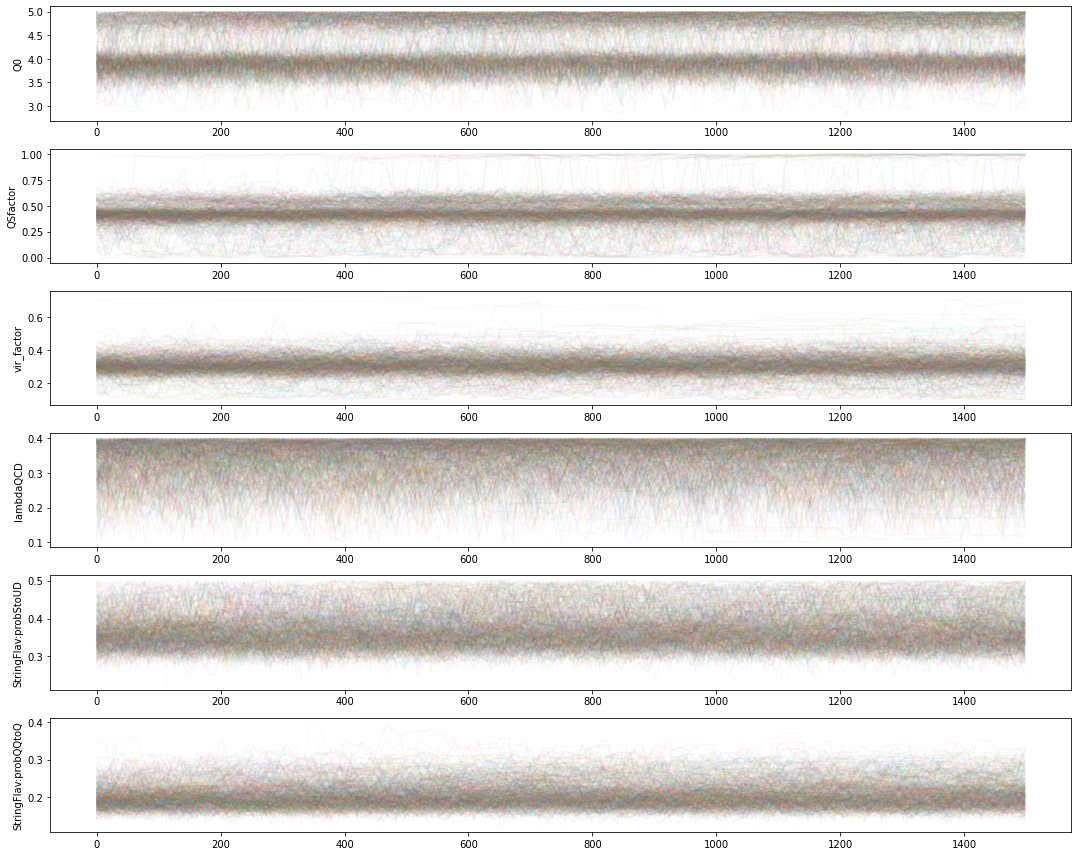

In [13]:
with chain.dataset() as d:
    W = d.shape[0]     # number of walkers
    S = d.shape[1]     # number of steps
    N = d.shape[2]     # number of paramters
    T = int(S / 200)   # "thinning"
    A = 20 / W
    figure, axes = plt.subplots(figsize = (15, 2 * N), ncols = 1, nrows = N)
    for i, ax in enumerate(axes):
        ax.set_ylabel(AllData["labels"][i])
        for j in range(0, W):
            ax.plot(range(0, S, T), d[j, ::T, i], alpha = A)
    plt.tight_layout()
    plt.savefig(indir+'MCMCSamples.pdf', dpi = 192)

Parameter Distributions

Q0: 4.96
QSfactor: 0.41000000000000003
vir_factor: 0.30700000000000005
lambdaQCD: 0.397
StringFlav:probStoUD: 0.355
StringFlav:probQQtoQ: 0.188


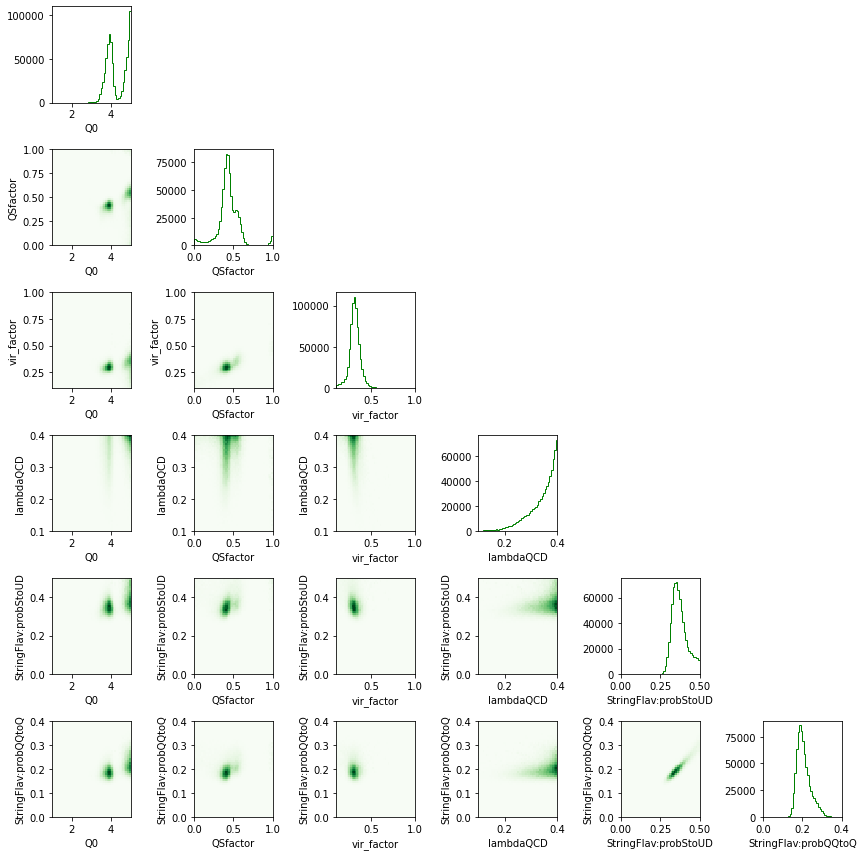

In [14]:
from numpy import average


NDimension = len(AllData["labels"])
Ranges = np.array(AllData["ranges"]).T
scale = 2
figure, axes = plt.subplots(figsize = (scale * NDimension, scale * NDimension), ncols = NDimension, nrows = NDimension)
Names = AllData["labels"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            y, x, _ = ax.hist(MCMCSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step', color='green')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])

            maxindex = 0
            maxy = y.max()
            for k,thisy in enumerate(y): 
                if(thisy == maxy): 
                    maxindex = k

            xmax = (x[maxindex]+x[maxindex+1])/2
            print(AllData["labels"][i] + ": " + str(xmax))
        if i>j:
            ax.hist2d(MCMCSamples[:, j], MCMCSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Greens')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')

    
plt.tight_layout()
plt.savefig(indir+'Correlation.pdf', dpi = 192)
# figure

[0.85 5.  ]


/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


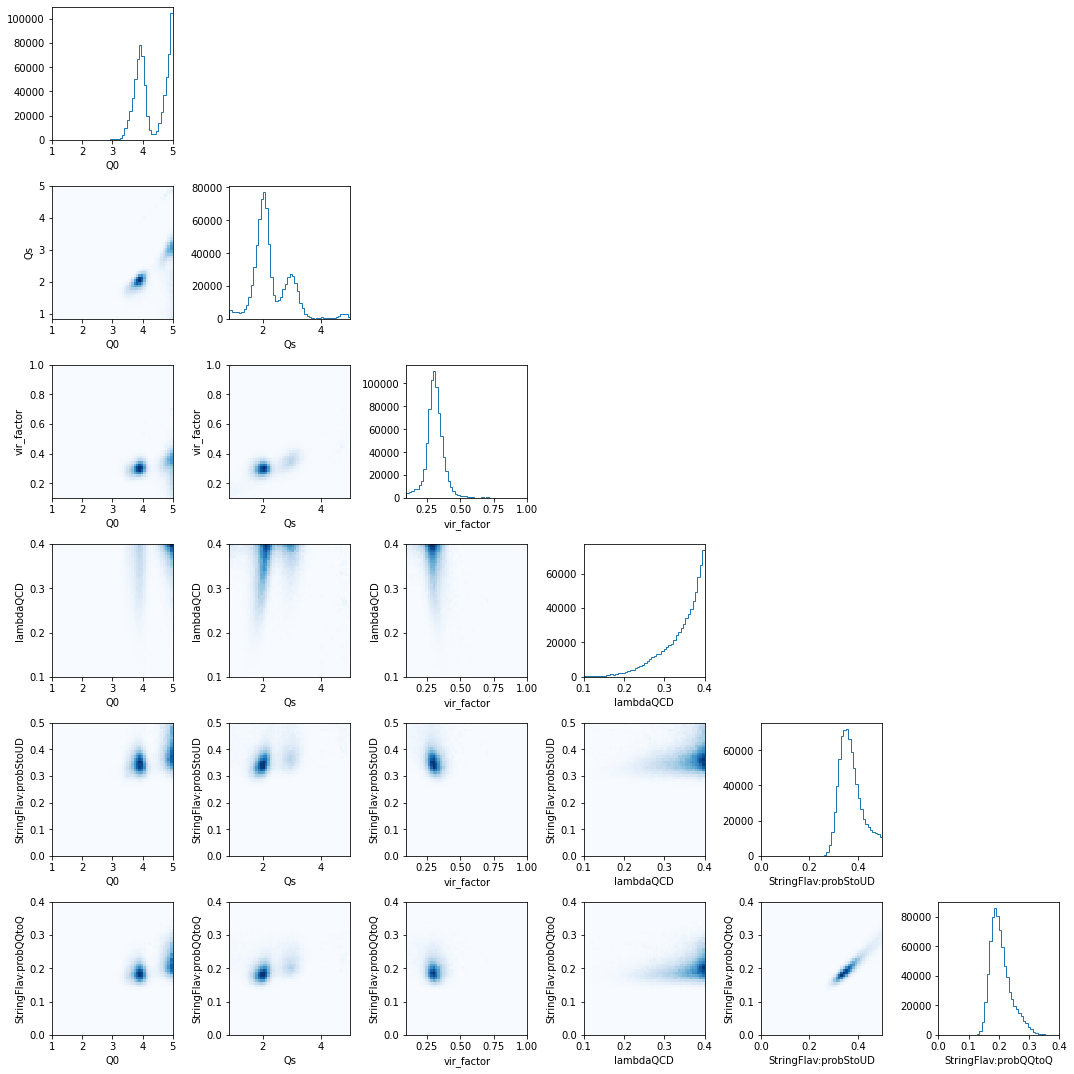

In [15]:
from pandas.tests.indexes import ranges


TransformedSamples = np.copy(MCMCSamples)
TransformedSamples[:,0] = MCMCSamples[:,0]
TransformedSamples[:,1] = (2*MCMCSamples[:,3]+0.05) + (MCMCSamples[:,0]-(2*MCMCSamples[:,3]+0.05))*MCMCSamples[:,1]
TransformedSamples[:,2] = MCMCSamples[:,2]
TransformedSamples[:,3] = MCMCSamples[:,3]
TransformedSamples[:,4] = MCMCSamples[:,4]
TransformedSamples[:,5] = MCMCSamples[:,5]

NDimension = 6
Ranges = np.array(AllData["ranges"]).T
figure, axes = plt.subplots(figsize = (15, 15), ncols = NDimension, nrows = NDimension)
Names = AllData["labels"]

Ranges[0][1] = 0.85
Ranges[1][1] = 5
print(Ranges[:,1])
Names[1] = "Qs"

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(TransformedSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
        if i>j:
            ax.hist2d(TransformedSamples[:, j], TransformedSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Blues')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
plt.savefig(indir+'TransformedCorrelation.pdf', dpi = 192)
# figure

Observables

{'EpEm91': {'Vac': {'kaon-xp': array([[14.70070806, 16.26290125, 18.10382557, ...,  2.09899428,
         1.44758732,  0.88785252],
       [13.92363921, 15.45635143, 16.94544725, ...,  2.0420135 ,
         1.4201022 ,  0.88685153],
       [13.29725291, 14.64263576, 16.4365089 , ...,  2.159239  ,
         1.47403548,  0.88651162],
       ...,
       [13.90360079, 15.40016505, 17.10560227, ...,  2.13650013,
         1.46898051,  0.89522954],
       [13.58077688, 14.98422141, 16.72110972, ...,  2.19417377,
         1.48687501,  0.88785615],
       [13.83123654, 15.32332145, 16.8864089 , ...,  2.12764011,
         1.46338047,  0.8870553 ]]), 'proton-xp': array([[ 8.86716964,  9.80097625, 10.57122041, ...,  0.8879242 ,
         0.57702132,  0.33623492],
       [ 8.82100436,  9.57405276, 10.22292085, ...,  0.8938736 ,
         0.59556707,  0.35692021],
       [ 8.20571394,  9.05019093,  9.75099965, ...,  0.80130301,
         0.50634587,  0.28300297],
       ...,
       [ 8.93776846,  9.838949

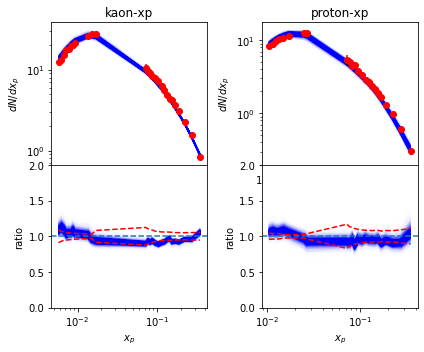

In [16]:
Examples = MCMCSamples[np.random.choice(range(len(MCMCSamples)), 2500), :]
TempPrediction = {"EpEm91": EmulatorEpEm91.predict(Examples)}

print(TempPrediction)

makeplot(AllData, plotvars, TempPrediction, "Posteriors", indir)

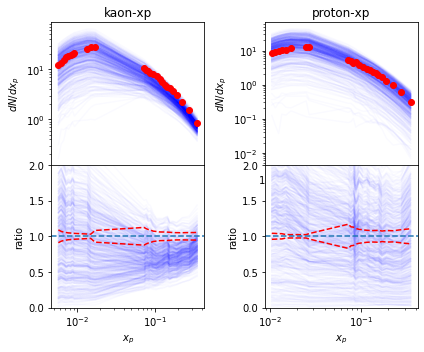

In [17]:
Examples = AllData["design"]
TempPrediction = {"EpEm91": EmulatorEpEm91.predict(Examples)}

makeplot(AllData, plotvars, TempPrediction, "Predicted Design", indir)

Priors

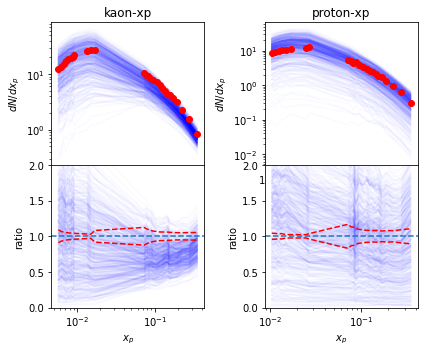

In [18]:
TempPrediction = AllData["model"]

makeplot(AllData, plotvars, TempPrediction, "Priors", indir)

In [19]:
# close all plots to save memory
plt.close('all')